In [1]:
from smr import File
import numpy as np
from matplotlib import pyplot as plt


In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091608/B091608_1218_Adapt.smr'
# f_name = '/mnt/data/kkarbasi/SimpleSpike-Felix/Felix 2006.09.06/Felix 2006.09.06 1313 List.smr'
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091608/B091608_1306_AdaptForward.smr'
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W120308_2/W120308_2_1714_List.smr'

In [4]:
smr_content = File(f_name)
smr_content.read_channels()

Not implemented (type = 6)
Not implemented (type = 6)
Not implemented (type = 6)
Not implemented (type = 5)
Not implemented (type = 5)


In [5]:
voltage_chan = smr_content.get_channel(0)
# HE_chan = smr_content.get_channel(1)
# VE_chan = smr_content.get_channel(2)

In [6]:
%%time
from kaveh.sorting.spikesorter import SimpleSpikeSorter

# Time range of data to process:
t_0 = 0 #s
t_end = 20 #s

idx_0 = int(np.round(t_0 / voltage_chan.dt))
idx_end = int(np.round(t_end / voltage_chan.dt))
prange = slice(idx_0, idx_end)
sss = SimpleSpikeSorter(voltage_chan.data[prange], voltage_chan.dt)
sss.run()


CPU times: user 8.88 s, sys: 5.29 s, total: 14.2 s
Wall time: 8.03 s


<IPython.core.display.Javascript object>


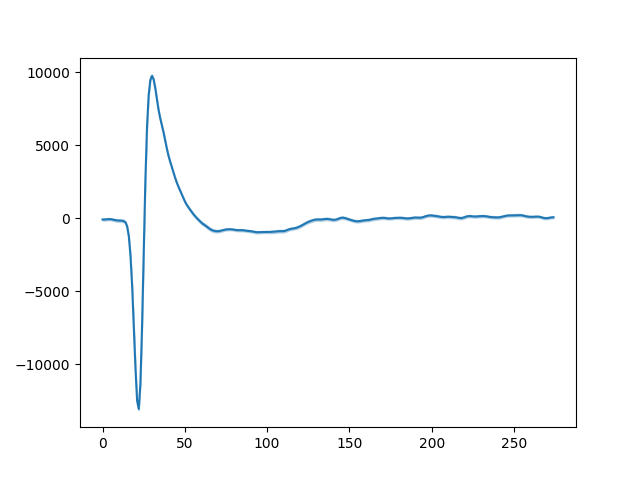

In [7]:
# Spike window (in seconds)
pre = 0.0005
post = 0.005

sss.set_spike_window(pre, post)
sss.plot_spike_waveforms_average()

# sss.plot_spike_peaks(figsize=(5,3))

In [ ]:
from neo.io import Spike2IO
from kaveh.toolbox import closest_argmin
neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]
# Assuming cs spike trains are saved in the 0th index of spike train channels
cs_spiketrain = np.array(seg.spiketrains[0])
cs_spiketrain = np.int32(cs_spiketrain/sss.dt)
cs_spiketrain = cs_spiketrain[np.where(np.logical_and(cs_spiketrain >= idx_0, cs_spiketrain < idx_end))]
cs_spike_indices = np.unique(closest_argmin(cs_spiketrain, sss.get_spike_indices()))

In [ ]:
np.asarray(seg.spiketrains[0])

In [ ]:
from kaveh.plots import axvlines
axvlines(plt.gca(), sss.get_spike_indices()[cs_spike_indices], color='g', alpha = 0.25, zorder=10)

In [ ]:
sss._align_spikes()
sss.plot_spike_waveforms_average()

pre_index = int(np.round(sss.pre_window / sss.dt))
post_index = int(np.round(sss.post_window / sss.dt))


cs_aligned_spikes = np.array([sss.voltage[i - pre_index : i + post_index ] for i in sss.get_spike_indices()[cs_spike_indices]])

cs_spikes_avg = np.mean(cs_aligned_spikes, axis = 0)
cs_spikes_std = np.std(cs_aligned_spikes, axis = 0)/np.sqrt(cs_aligned_spikes.shape[0])
x = np.arange(0, cs_aligned_spikes.shape[1])

l = plt.plot(x, cs_spikes_avg, 'r')
plt.fill_between(x, cs_spikes_avg - cs_spikes_std, cs_spikes_avg + cs_spikes_std, color=l[0].get_color(), alpha=0.25)





In [ ]:
plt.figure()
plt.plot(cs_spikes_std)

# plt.figure()
plt.plot(np.std(sss.aligned_spikes, axis = 0)/np.sqrt(sss.aligned_spikes.shape[0]), 'r')

In [ ]:
plt.figure()

for cs in cs_aligned_spikes:
    plt.plot(cs, alpha=0.10, color='k')
    
plt.plot(cs_spikes_avg, 'r')

In [ ]:
plt.figure()

for cs in cs_aligned_spikes:
    plt.plot(cs, alpha=0.10, color='k')
    
plt.plot(cs_spikes_avg, 'r')

plt.figure()

for ss in sss.aligned_spikes[0:100]:
        plt.plot(ss, alpha=0.10, color='k')
plt.plot(np.mean(sss.aligned_spikes[0:100], axis=0))


In [ ]:
# freq_range = (0,5000)

# max_powers = []
# fig, ax = plt.subplots()
# for wf in sss.aligned_spikes:
#     yf = scipy.fftpack.fft(wf)
#     N = wf.size
#     xf = np.linspace(0.0, 1.0/(2.0*sss.dt), N/2)
#     mask = (xf < freq_range[1]) & (xf >= freq_range[0])
    
#     power_spectrum = 2.0/N * np.abs(yf[:N//2])
#     max_powers = max_powers + [np.max(power_spectrum[mask])]
    
    
#     plt.plot(xf[mask], power_spectrum[mask])

# max_powers = np.asarray(max_powers)

max_powers = sss._find_max_powers((0,5000))


In [ ]:
cs_indices = sss._cluster_spike_waveforms_by_freq(cov_type = 'tied', gmm_nc = 2, plot_hist = True, freq_range=(0,1000))

In [ ]:
# Remove detected cs that don't produce a pause in simple spikes for pause_time
pause_time = 0.015 #s

print(cs_indices.shape)
to_delete = []
for i, csi in enumerate(cs_indices):
    if  (sss.get_spike_indices()[np.squeeze(np.where(sss.get_spike_indices() == csi)) + 1] - csi) * sss.dt < pause_time:
        to_delete = to_delete + [i]
        
mask = np.ones(cs_indices.shape, dtype = bool)
mask[to_delete] = False
cs_indices = cs_indices[mask]
print(cs_indices.shape)
            

<IPython.core.display.Javascript object>


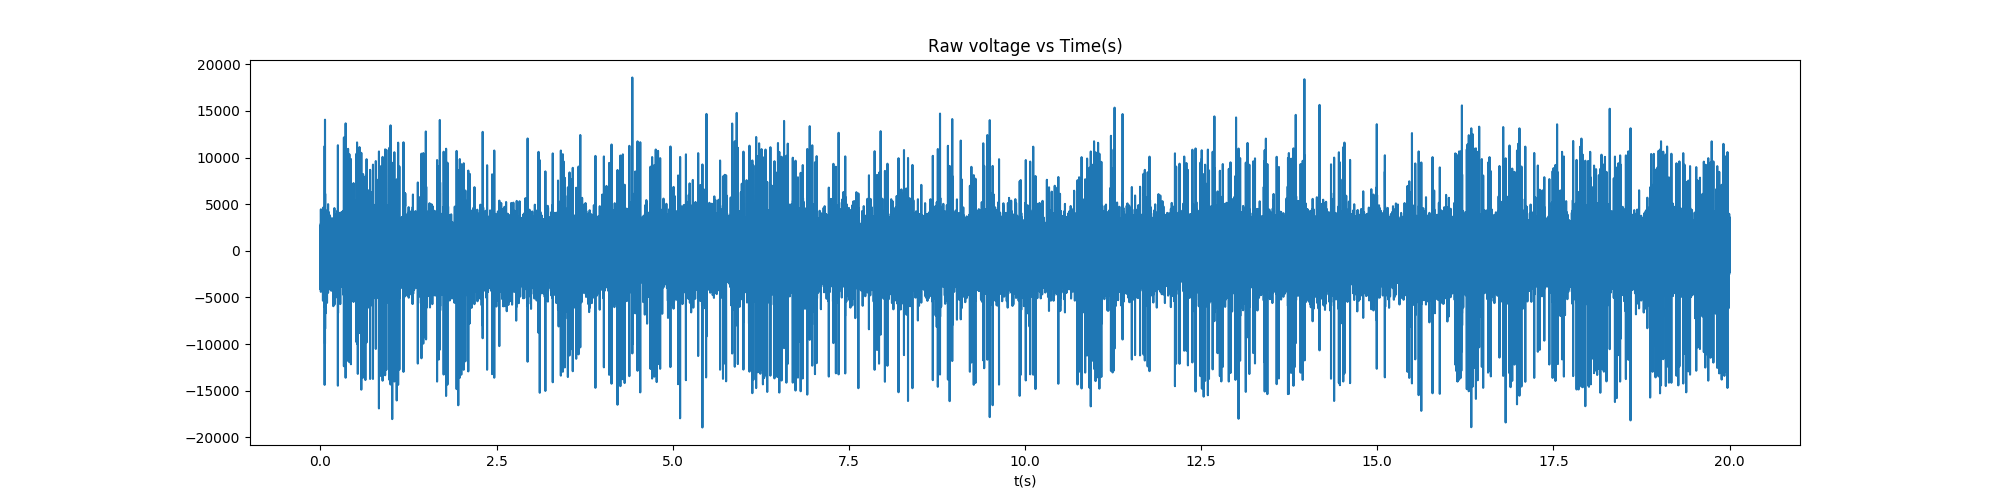

In [8]:
sss.plot_voltage(figsize=(20,5))

In [9]:
from kaveh.plots import axvlines
axvlines(plt.gca(), cs_indices * sss.dt, color='r', alpha=0.25, zorder=10)
# axvlines(plt.gca(), sss.get_spike_indices()[cs_spike_indices], color='g', alpha = 1, zorder=10)
plt.plot(sss.get_spike_indices()[cs_spike_indices] * sss.dt, [0]*sss.get_spike_indices()[cs_spike_indices].shape[0], 'm*')
# plt.plot(sss.get_spike_indices()[cs_spike_indices[109]], 0, 'm*')

NameError: name 'cs_indices' is not defined

In [ ]:
sss.get_spike_indices()[cs_spike_indices[19]]

In [ ]:
false_positives = np.setdiff1d(cs_indices, np.intersect1d(cs_indices, sss.get_spike_indices()[cs_spike_indices]))
false_positives

In [ ]:

cd_pauses = sss.get_spike_indices()[cs_spike_indices+1] - sss.get_spike_indices()[cs_spike_indices]

In [ ]:
plt.figure()
plt.hist(cd_pauses*sss.dt, bins=500)
print(np.min(cd_pauses*sss.dt))
# print(np.where(cd_pauses*sss.dt <= 0.0140))


In [ ]:
np.min(np.diff(sss.get_spike_indices())*sss.dt)

In [ ]:
    sss.get_spike_indices()[np.squeeze(np.where(sss.get_spike_indices() == cs_indices[0])) + 1]

In [ ]:
import scipy
scipy.__version__